In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

!pip install pydot
!rm -rf ./logs/ 

# Working with Tensorflow 2.0


[**TensorFlow**](https://www.tensorflow.org/) is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries, and community resources that lets researchers push the state-of-the-art in ML and developers can easily build and deploy ML-powered applications.

TensorFlow library is a free and open-source software library for *dataflow programming* (models a program as a directed graph of the data flowing between operations, thus implementing dataflow principles and architecture) and *differentiable programming* (programs can be differentiated throughout, usually via automatic differentiation. This allows for gradient based optimization of parameters in the program, often via gradient descent) across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks. It is used for both research and production at Google.

TensorFlow was originally developed by researchers and engineers working on the Google Brain team within Google's Machine Intelligence Research organization to conduct machine learning and deep neural networks research. The system is general enough to be applicable in a wide variety of other domains, as well. It is one of the most popular libaries for machine learning with neural networks.

TensorFlow provides stable Python and C++ APIs, as well as non-guaranteed backward compatible API for other languages.

### Tensorflow tensors

A tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes (similar to `numpy.ndarray`).

When we write a TensorFlow program, we mainly operate and pass around `tf.Tensor` objects, which represents a partially defined data object that will eventually produce a value. In a Tensorflow program, we specify how these `tf.Tensor`'s link into a computation graph. We can then run the computation graph to get the output (based on an input), and use differential properties of the graph to optomise for parameter (`tf.Tensor` nodes) in the program. `tf.Tenor`'s can reside in GPU or CPU memory. Tensorflow supports a rich library of operations (`tf.add`, `tf.matmul`, `tf.linalg.inv` etc) that consume and produce `tf.Tensors`'s. These operations also automatically convert to native Python types too.


In [2]:
import tensorflow as tf
print("TensorFlow version : {}\n\n".format(tf.__version__))

print(tf.add(1, 3))
print(tf.add([2, 3], [6, 6]))
print(tf.square(2))
print(tf.reduce_sum([4, 3, 2]))

# Operator overloading is also supported
print(tf.square(3) + tf.square(2))

TensorFlow version : 2.1.0


tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


Each `tf.Tensor` has a datatype and a shape

In [3]:
x = tf.constant([[4, 3]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[4 3]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


Tensors differ from numpy arrays as they are *immutable*, can be computed and stored in the GPU or CPU.

However it easy to convert from a `tf.Tensor` to a `np.ndarray`. Tensorflow automatically converts numpy arrays to `tf.Tensors`.

In [4]:
ndarray = np.array([[1, 2], [3, 4]])

# Tensorflow converts ndarray to a tensor after an operation
tensor = tf.multiply(ndarray, 2)
print('Tensor :\n', tensor)

# Tensorflow converts ndarray to a tensor after operator overloading operation
tensor = tf.constant(2) * ndarray
print('\nTensor :\n', tensor)

# Numpy can convert a tensor to a numpy ndarray
numpy_array = np.multiply(tensor, 2)
print('\nNumpy ndarray :\n', numpy_array)

# It does this by calling the .numpy() method explicity
print('\nNumpy ndarray : \n', tensor.numpy())

Tensor :
 tf.Tensor(
[[2 4]
 [6 8]], shape=(2, 2), dtype=int64)

Tensor :
 tf.Tensor(
[[2 4]
 [6 8]], shape=(2, 2), dtype=int32)

Numpy ndarray :
 [[ 4  8]
 [12 16]]

Numpy ndarray : 
 [[2 4]
 [6 8]]


We can also index tensors with the same convention as numpy.

In [5]:
print(tensor[0, 0])
print('\n', tensor[:, 1])

tf.Tensor(2, shape=(), dtype=int32)

 tf.Tensor([4 8], shape=(2,), dtype=int32)


Tensorflow operations can be accelerated by parralelised to be computed on a GPU. By default, Tensorflow automatically decides whether to use the GPU or CPU for an operation (copying the memory between them if necessary). 

In [6]:
x = tf.random.uniform([4, 4])

print("List if there is a GPU available : ",
      tf.config.experimental.list_physical_devices("GPU"))

print("\nIs the Tensor on GPU #0: ", x.device.endswith('GPU:0'))

List if there is a GPU available :  []

Is the Tensor on GPU #0:  False


The `tf.Tensor` has the same data type `tf.Dtype` (e.g. {`int32`, `float32`, `string`}) for each element. There are some special types of tensors, such as `tf.Variable`, `tf.constant`, `tf.SparseTensor`, `tf.placeholder`. The data of a tensor is immutable, meaning that in a single run of the graph the data doesn't change.

Depending on the dimension of the tensor, we get the following

|Dimension|Classical mathematical form|
|---|---|
| 0       | Scalar                    |
| 1       | Vector                    |
| 2       | Matrix                    |
| 3       | 3-Tensor                  |
| n       | n-Tensor                  |



A variable, i.e. `tf.Variable` is the best way to represent shared state, and the value can be changed by running operations on it. Higher level libraries like `keras` use `tf.Variable`'s to store model parameters.

In [7]:
zeros = tf.Variable(tf.zeros([2, 3]))
print(zeros)

scalar = tf.Variable(5)
print('\n', scalar)

# To assign a value to an already set variable we use the .assign() method
scalar.assign(4)
print('\n', scalar)

# We can also explicitly read a value using the .read_value() method
print('\n', scalar.read_value())

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

 <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=5>

 <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=4>

 tf.Tensor(4, shape=(), dtype=int32)


### Eager execution

A very useful feature in tensorflow 2.0, enabled by default is *eager execution*, which is an imperative programming enviroment that evaluates operations immediately, without building graphs: operations return definitive values rather than constructing a computational graph to run later. This makes it easy to start working with Tensorflow and debug models. This allows use of Pythons data structures, flexibility how we can structure our code and using Python control flow as well. This supports GPU operations as well.

In [8]:
print('Tensorflow {}, executing early by default\nAre we evaluating operations immediately ? : {}'.format(
    tf.__version__, tf.executing_eagerly()))

Tensorflow 2.1.0, executing early by default
Are we evaluating operations immediately ? : True


In [9]:
# When we run Tensorflow operations the result is immediately returned
x = tf.constant(2, name='x')
y = tf.constant(3, name='y')
z = x * y

print('z = {}\n As'.format(z))
print('z = {} = x ({}) * y ({})'.format(z, x, y))

z = 6
 As
z = 6 = x (2) * y (3)


In [10]:
# Visualise the computation graph

# The function to be traced.
@tf.function
def my_func(x, y):
    # A simple hand-rolled layer.
    return x*y


# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.constant(2, name='x')
y = tf.constant(3, name='y')

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
    tf.summary.trace_export(
        name="my_func_trace",
        step=0,
        profiler_outdir=logdir)

print('z = {} = x ({}) * y ({})'.format(z, x, y))

%tensorboard --logdir logs/func

z = 6 = x (2) * y (3)


## Automatic differentiation

[Automatic differentiation](https://www.wikiwand.com/en/Automatic_differentiation) (AD) is a set of techniques to numerically evaluate the derivative of a function specified by a computer program. AD exploits the fact that every computer program, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). By applying the chain rule repeatedly to these operations, derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor more arithmetic operations than the original program.

#### The chain rule, forward and reverse accumulation

Fundamental to AD is the decomposition of differentials provided by the chain rule. For the simple composition 

$$\begin{align}
y &= f(g(h(x))) = f(g(h(w_0))) = f(g(w_1)) = f(w_2) = w_3 \\
w_0 &= x \\ 
w_1 &= h(w_0) \\
w_2 &= g(w_1) \\
w_3 &= f(w_2) = y
\end{align}$$

the chain rule gives

$$\frac{dy}{dx} = \frac{dy}{dw_2} \frac{dw_2}{dw_1} \frac{dw_1}{dx}$$

Usually, two distinct modes of AD are presented, *forward accumulation* (or *forward mode*) and *reverse accumulation* (or *reverse mode*). Forward accumulation specifies that one traverses the chain rule from inside to outside (that is, first compute $dw_1/dx$ and then $dw_2/dw_1$ and at last $dy/dw_2$), while reverse accumulation has the traversal from outside to inside (first compute $dy/dw_2$ and then $dw_2/dw_1$ and at last $dw_1/dx$). More succinctly,
1. *forward accumulation* computes the recursive relation: $\frac{dw_i}{dx} = \frac{dw_i}{dw_{i-1}} \frac{dw_{i-1}}{dx}$ with $w_3 = y$, and,
2. *reverse accumulation* computes the recursive relation: $\frac{dy}{dw_i} = \frac{dy}{dw_{i+1}} \frac{dw_{i+1}}{dw_{i}}$ with $w_0 = x$.
Generally, both forward and reverse accumulation are specific manifestations of applying the operator of program composition, fixing the appropriate one of the two mappings $(w,y)$. Tensorflow uses *reverse accumulation*.

#### Reverse accumulation

In reverse accumulation AD, the *dependent variable* to be differentiated is fixed and the derivative is computed *with respect to* each sub-expression recursively. In a pen-and-paper calculation, the derivative of the *outer* functions is repeatedly substituted in the chain rule:

$$\frac{\partial y}{\partial x}
= \frac{\partial y}{\partial w_1} \frac{\partial w_1}{\partial x}
= \left(\frac{\partial y}{\partial w_2} \frac{\partial w_2}{\partial w_1}\right) \frac{\partial w_1}{\partial x}
= \left(\left(\frac{\partial y}{\partial w_3} \frac{\partial w_3}{\partial w_2}\right) \frac{\partial w_2}{\partial w_1}\right) \frac{\partial w_1}{\partial x}
= \cdots$$

In reverse accumulation, the quantity of interest is the *adjoint*, denoted with a bar ($w̄$); it is a derivative of a chosen dependent variable with respect to a subexpression $w$:

$\bar w = \frac{\partial y}{\partial w}$

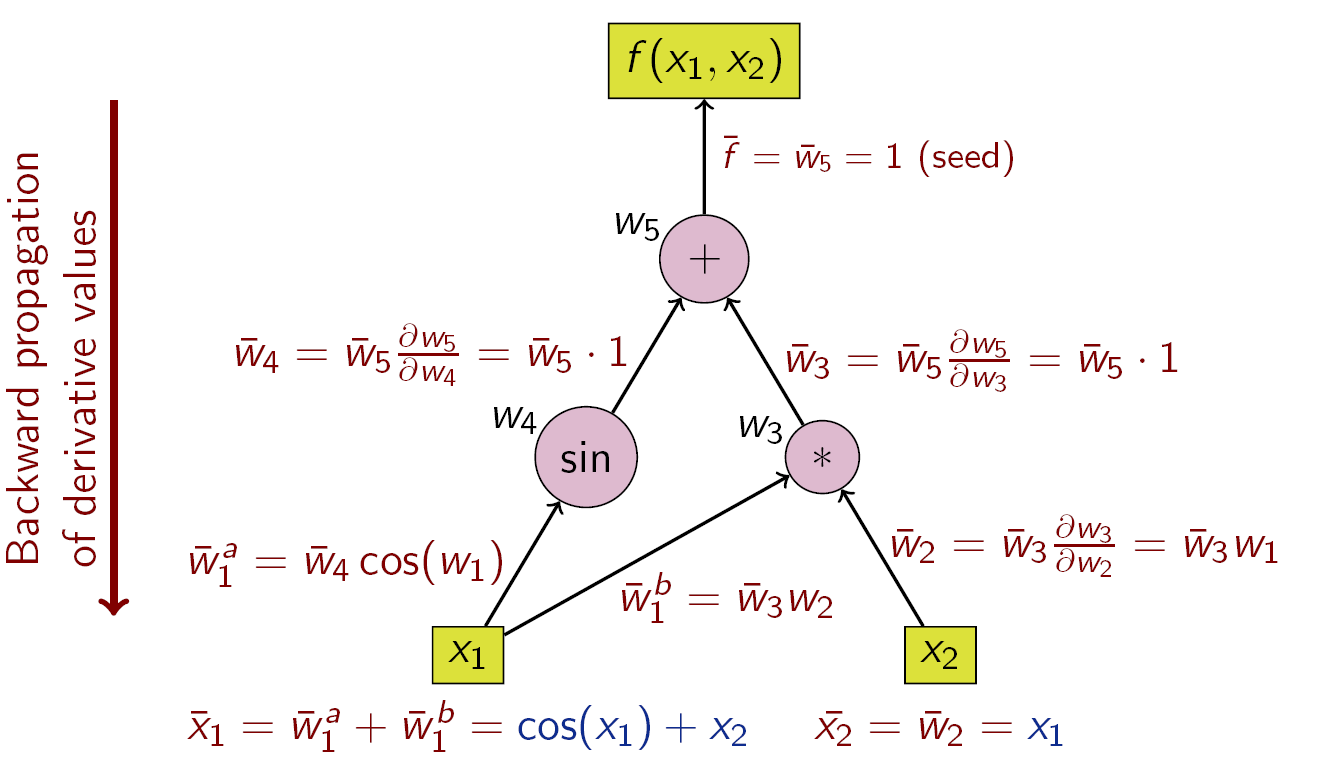

Reverse accumulation traverses the chain rule from outside to inside, or in the case of the computational graph in the diagram, from top to bottom. The example function is scalar-valued, and thus there is only one seed for the derivative computation, and only one sweep of the computational graph is needed to calculate the (two-component) gradient.
This is only half the work when compared to forward accumulation, but reverse accumulation requires the storage of the intermediate variables $w-i$ as well as the instructions that produced them in a data structure known as a Wengert list (or "tape") which may consume significant memory if the computational graph is large.
This can be mitigated to some extent by storing only a subset of the intermediate variables and then reconstructing the necessary work variables by repeating the evaluations, a technique known as rematerialization. Checkpointing is also used to save intermediary states (Tensorflow supports checkpointing).

The operations to compute the derivative using reverse accumulation are shown in the table below (note the reversed order):
$$\begin{array}{l}
\text{Operations to compute derivative}
\\ \hline
\bar w_5 = 1 \text{ (seed)}
\\
\bar w_4 = \bar w_5
\\
\bar w_3 = \bar w_5
\\
\bar w_2 = \bar w_3 \cdot w_1
\\
\bar w_1 = \bar w_3 \cdot w_2 + \bar w_4 \cdot \cos w_1
\end{array}
$$

The data flow graph of a computation can be manipulated to calculate the gradient of its original calculation. This is done by adding an adjoint node for each primal node, connected by adjoint edges which parallel the primal edges but flow in the opposite direction. The nodes in the adjoint graph represent multiplication by the derivatives of the functions calculated by the nodes in the primal. For instance, addition in the primal causes fanout in the adjoint; fanout in the primal causes addition in the adjoint; In terms of weight matrices, the adjoint is the transpose. Addition is the covector $[1 \cdots 1]$, since $[1 \cdots 1]
\left[\begin{smallmatrix}x_1 \\ \vdots \\ x_n \end{smallmatrix}\right] = x_1 + \cdots + x_n,$ and fanout is the vector $\left[\begin{smallmatrix}1 \\ \vdots \\ 1 \end{smallmatrix}\right],$ since $\left[\begin{smallmatrix}1 \\ \vdots \\ 1 \end{smallmatrix}\right][x] = \left[\begin{smallmatrix}x \\ \vdots \\ x \end{smallmatrix}\right].$ a unary function $y=f(x)$ in the primal causes $x̄=ȳf′(x)$ in the adjoint; etc.

Reverse accumulation is more efficient than forward accumulation for functions $f : ℝ^{n} → ℝ^{m}$ with $m ≪ n$ as only $m$ sweeps are necessary, compared to $n$ sweeps for forward accumulation.

Reverse mode AD was first published in 1976 by Seppo Linnainmaa.

Backpropagation of errors in multilayer perceptrons, a technique used in machine learning, is a special case of reverse mode AD.


### AD and Gradient Tape in TensorFlow

The `tf.GradientTape` records operations for automatic differentiation, computing the gradient of a computation with respect to its inputs. Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched". Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using *reverse accumulation* (explained above).

E.g.

Suppose we have the network for

$$ y = x^2 $$

We can compute analytically $\frac{dy}{dx}$ $$\frac{dy}{dx}=2x$$

In [11]:
x = tf.constant(5.0)

with tf.GradientTape() as t:
    t.watch(x)
    y = x * x

dy_dx = t.gradient(y, x)

print('dy_dx : ', dy_dx)

dy_dx :  tf.Tensor(10.0, shape=(), dtype=float32)


In [12]:
x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(x)
    k = tf.matmul(x, x)
    y = tf.add(k, tf.ones((2, 2)))

dy_dk = t.gradient(y, k)

print('dy_dk : ', dy_dx)

dy_dk :  tf.Tensor(10.0, shape=(), dtype=float32)


In [13]:
x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    k = tf.matmul(x, x)
    y = tf.add(k, tf.ones((2, 2)))

dy_dk = t.gradient(y, k)
dy_dx = t.gradient(y, x)

del t  # Drop the rerefence to the tape when finished with it

print('dy_dk : ', dy_dx)
print('dy_dx : ', dy_dx)

dy_dk :  tf.Tensor(
[[ 7. 11.]
 [ 9. 13.]], shape=(2, 2), dtype=float32)
dy_dx :  tf.Tensor(
[[ 7. 11.]
 [ 9. 13.]], shape=(2, 2), dtype=float32)


Tapes record operations as they execute therefore they naturally handle Python control flow, such as `if` and `while`

In [14]:
def f(x, y):
    output = 6.0
    for i in range(y):
        if i > 2 and i < 6:
            output = tf.multiply(output, x)
    return output


def grad(x, y):
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x, y)
    return t.gradient(out, x)


x = tf.Variable(2.0)

print(grad(x, 6))
print(grad(x, 5))
print(grad(x, 4))

tf.Tensor(72.0, shape=(), dtype=float32)
tf.Tensor(24.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


In [15]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        y = x * x

dy_dx = gg.gradient(y, x)
d2y_dx2 = g.gradient(dy_dx, x)

## Ridge Regression with TensorFlow

Recall that we looked at ridge regression in section 2, to recap:

https://en.wikipedia.org/wiki/Tikhonov_regularization
$y=wx_i$ where $w\in{\rm I\!R}^{n}$

i.e. if dimensions $n=2$;    $y_{i} = f(x_{i}) = \begin{bmatrix} w_{0}, w_{1} \end{bmatrix} \begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix} = w_{0}x_{0} + w_{1}x_{1}$

Model : $\hat{y}=\mathbf{X}w$

Cost function : $$ J(w)= \sum_i (w^T x_i - y_i)^2 = {\bf ||} \mathbf{X} w-y {\bf ||}^2_{2} $$

$$\min_{w} \, (\mathbf{y} - \mathbf{X} w)^\mathsf{T}(\mathbf{y} - \mathbf{X} w) $$

$$\frac{\partial (\mathbf{y} - \mathbf{X} w)^\mathsf{T}(\mathbf{y} - \mathbf{X} w)}{\partial w}=-2X^T(y-\mathbf{X} w)$$

$$\frac{\partial (\mathbf{y} - \mathbf{X} w)^\mathsf{T}(\mathbf{y} - \mathbf{X} w)}{\partial w}=-2X^T(y-\mathbf{X} w) = 0$$

$$y=\mathbf{X} w$$

### Solution with the Analytic (Exact algebraic solution)
i.e. the analytical solution for the model parameters is to compute :$$w = \mathbf{X}^{-1} y$$


In [16]:
# Recall the Ridge Regression example from section 2-2
from sklearn import datasets
digits = datasets.load_digits()

(X, y) = datasets.load_digits(return_X_y=True)

# Split the labelled dataset into a training set and test set
index_to_split = -1
X_train = X[:index_to_split]
y_train = np.array([y[:index_to_split]])
X_test = X[index_to_split:]
y_test = np.array([y[index_to_split:]])

# Calculate the analytical solution
X_train_inv = tf.linalg.pinv(X_train)
y_train = tf.transpose(tf.Variable(y_train, dtype=tf.float64))

w = tf.matmul(X_train_inv, y_train)
print('w: {}'.format(w.numpy().flatten()))

w: [ 1.62642066e-14  9.40249350e-02 -3.67939617e-03 -7.72167429e-03
  7.49514697e-02  1.15243563e-02 -2.72158636e-02 -7.31904304e-03
  1.00102690e+00 -2.84132215e-02  1.18887868e-01  6.59994113e-02
 -5.58787175e-02 -7.04137172e-02  9.65429164e-02  2.56033005e-01
 -7.29405068e-01  2.40605548e-02  7.76124220e-02 -2.29357716e-02
 -5.66039721e-02  5.81134072e-02 -4.91673806e-02 -2.62755693e-01
 -9.08254598e-01 -1.49425933e-01  5.59359249e-02  8.97465435e-02
  8.39772547e-02  9.83482587e-02  1.86692450e-03 -2.97298764e+00
  2.33680455e-14 -1.54851687e-01 -8.97570476e-03  1.39494684e-01
 -3.67398683e-02  5.46737441e-02 -9.53756017e-03  9.30683775e-16
  1.00930061e-01  1.23968401e-01 -1.37042140e-02  5.34285543e-03
  1.30949507e-01  5.51389202e-02  2.24650594e-02  7.76787978e-03
  6.14807150e-01  2.67348801e-02  1.20233616e-03 -6.19644555e-02
 -2.06960828e-01 -3.39245068e-02  1.05783054e-01 -1.40682284e-01
 -1.01420937e+00 -1.13249749e-01  2.06527116e-02 -4.39417720e-02
  1.85650152e-02 -6.65

In [17]:
# Test the model
y_hat = X_test @ w
print(y_hat)
print(w.shape)

tf.Tensor([[9.30939946]], shape=(1, 1), dtype=float64)
(64, 1)


y_hat: [[9.30939946]], rounds to 9.0
Actual y label: [[8]]


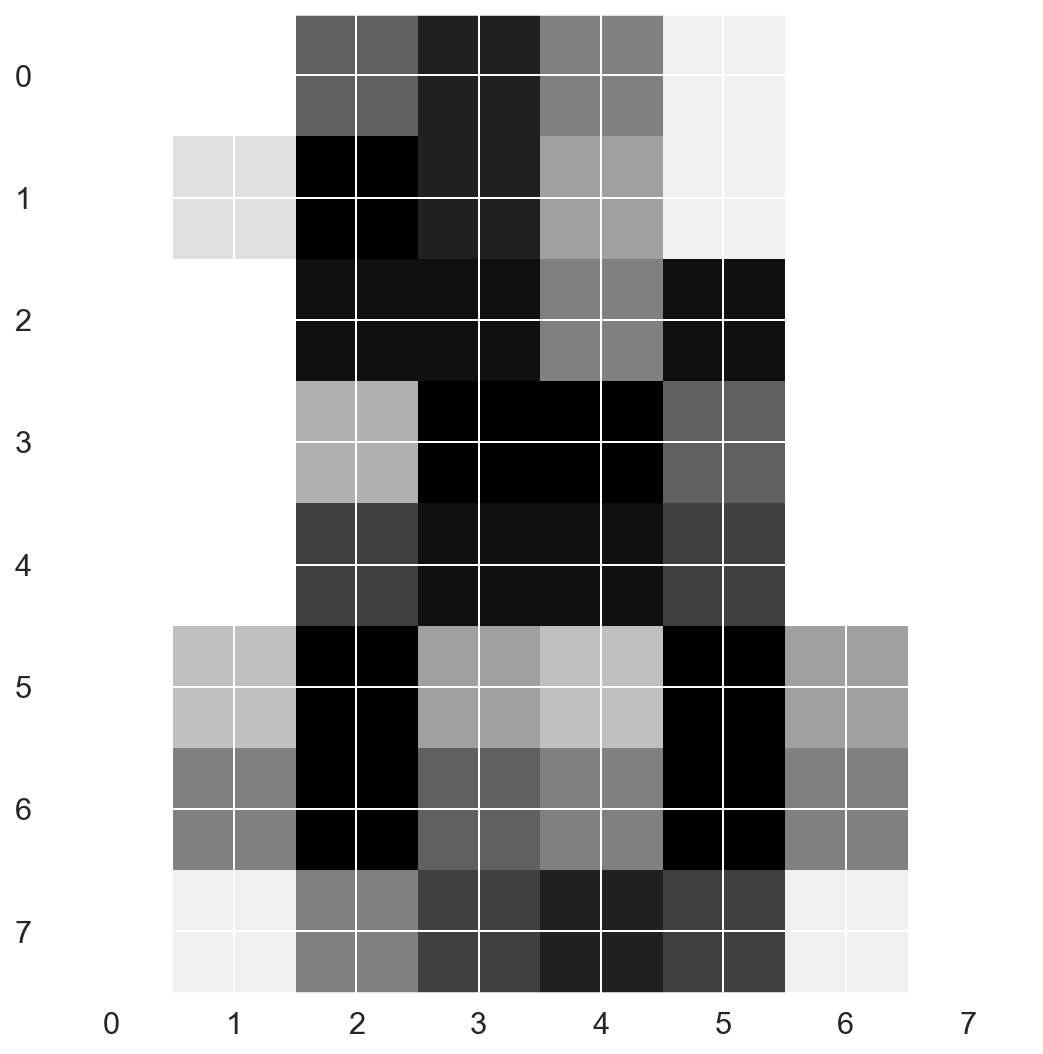

In [18]:
print('y_hat: {}, rounds to {}'.format(y_hat, np.round(y_hat).item(0)))
print('Actual y label: {}'.format(y_test))
plt.figure()
plt.imshow(16 - digits.images[-1], cmap='gray')
plt.show()

### Solution with Batch Gradient Descent (Using TensorFlow)

Lets train the ridge regression classifier this time using gradient descent, recall the gradient of the cost function is :

$$ J(w)= \sum_i (w^T x_i - y_i)^2 = {\bf ||} \mathbf{X} w-y {\bf ||}^2_{2} $$

Our update equation for $w$ is 

$$ w \leftarrow w - \eta \frac{\partial J(\bf{w}, y_i)}{\partial \bf{w}} $$

We will use `tf.Variable`'s to represent the parameters of the model, and we can use `tf` methods to read and update the stored value such as `tf.assign_sub` etc. These are mutable in the tensorflow computation graph. We will do the following:

1. Define the model
2. Define a loss function
3. Train using the training data and use an *optomizer* to adjust the variables to fit the data

To recap our model is : $\hat{y}=\mathbf{X}w$

Starting loss :  tf.Tensor(37.454681051980394, shape=(), dtype=float64)
Lowest possible training loss : 3.4116052683219555

Epoch 0: loss=37.454681051980394
Epoch 1: loss=22.40175169292075
Epoch 2: loss=18.855612649130098
Epoch 3: loss=17.80754147512685
Epoch 4: loss=17.310296654471557
Epoch 5: loss=16.94257095883113
Epoch 6: loss=16.61282246189918
Epoch 7: loss=16.300794683242827
Epoch 8: loss=16.00166054325713
Epoch 9: loss=15.713951059960158
Epoch 191: loss=5.404992943589579
Epoch 192: loss=5.395234940282464
Epoch 193: loss=5.3855673835957205
Epoch 194: loss=5.375988996111795
Epoch 195: loss=5.366498524016606
Epoch 196: loss=5.357094736573996
Epoch 197: loss=5.347776425613824
Epoch 198: loss=5.3385424050333015
Epoch 199: loss=5.329391510311208


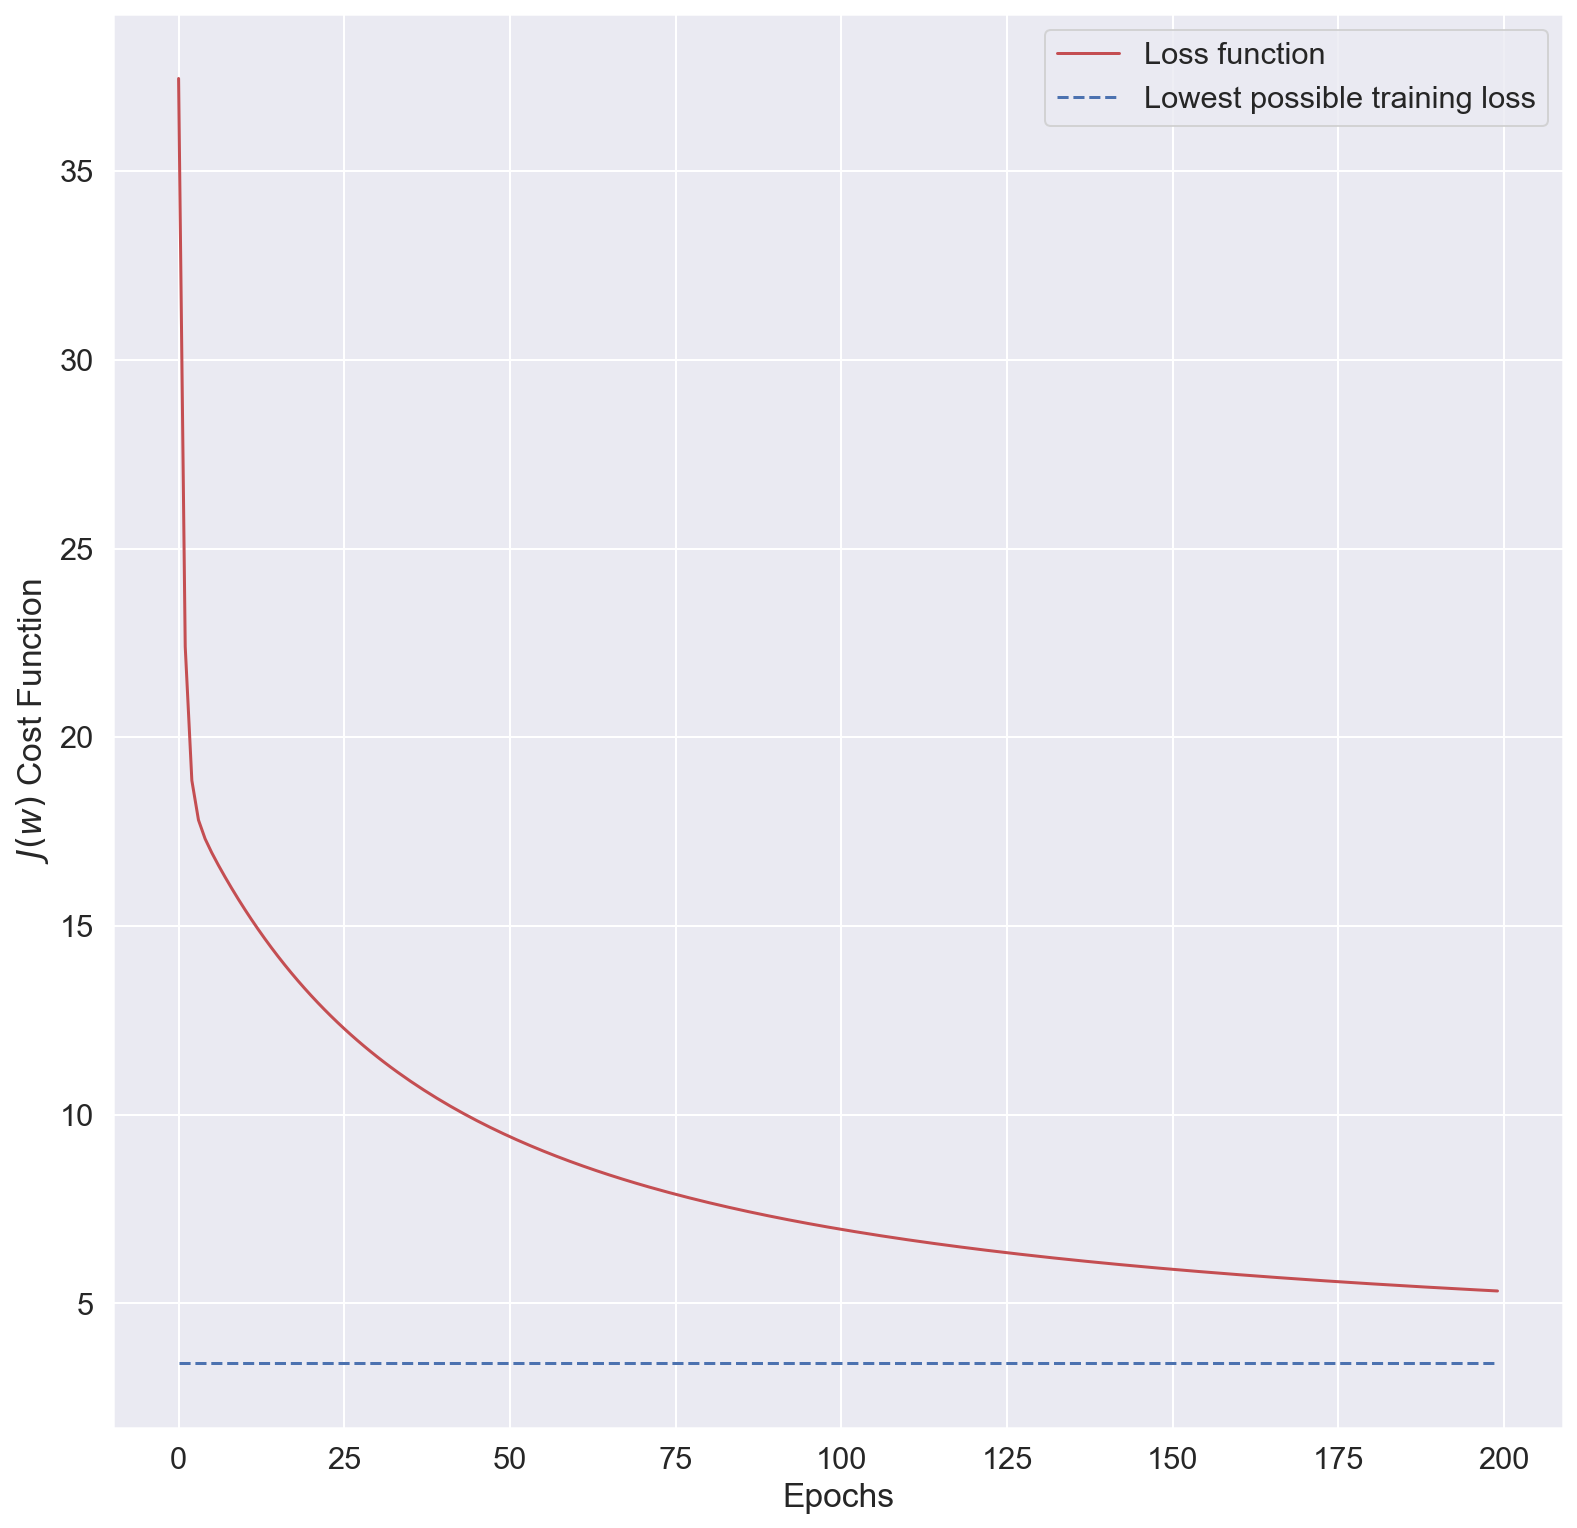

In [19]:
# 1. Defining our model
class RidgeRegression(object):
    def __init__(self):
        # Intialise parameter values
        self.w = tf.Variable(tf.random.normal(
            [64, 1], stddev=0.1, dtype=tf.float64, seed=0))

    # Actual model
    def __call__(self, X):
        return X @ self.w

# 2. Define the loss function


def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(predicted_y - target_y))

# 3. Using gradient descent define a training function


def train(ridge_regression, train_X, train_y, learning_rate):
    with tf.GradientTape() as t:
        t.watch(ridge_regression.w)
        current_loss = loss(train_y, ridge_regression(train_X))
    dw = t.gradient(current_loss, ridge_regression.w)
    ridge_regression.w.assign_add(- learning_rate * dw)


# # Putting it all together on the digits dataset
ridge_regression = RidgeRegression()

print('Starting loss : ', loss(y_train, ridge_regression(X_train)))
print('Lowest possible training loss : {}\n'.format(loss(y_train, X_train @ w)))

# Collect history of loss function
losses = []
epochs = range(200)
for epoch in epochs:
    current_loss = loss(y_train, ridge_regression(X_train))
    losses.append(current_loss)
    train(ridge_regression, X_train, y_train, learning_rate=0.0001)
    if epoch < 10 or epoch > 190:
        print('Epoch {}: loss={}'.format(epoch, current_loss))


# Let's plot it all
plt.figure(figsize=(13, 13))
plt.plot(epochs, losses, 'r')
plt.plot([loss(y_train, X_train @ w)] * len(epochs), 'b--')
plt.legend(['Loss function', 'Lowest possible training loss'])
plt.xlabel('Epochs')
plt.ylabel('$J(w)$ Cost Function')
plt.show()